# Week 5 - CycleGAN to create Monet Paintings

## Part 1: Description of the Problem and Data

This project is about taking regular photos and changing them to look like Monet-style paintings. To do this, we’ll use a special type of AI called a GAN, which has two parts: a generator and a discriminator. The generator makes new images, while the discriminator tries to tell if an image is real or made by the generator. They both improve by competing with each other — the generator tries to fool the discriminator, and the discriminator tries not to be fooled.

We’re using about 550MB of image data, which includes two types of pictures: Monet paintings and everyday photos. These pictures are unpaired, meaning there’s no matching photo for each painting. Because of this, we’ll use a type of GAN called CycleGAN, which is good for working with unpaired image data. We’ll explain why we chose CycleGAN in more detail later in the notebook.


I will be importing important libraries.

In [196]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image

from tqdm import tqdm
import shutil

from pathlib import Path

In [197]:
MONET_PATH = "/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg"
PHOTO_PATH = "/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/monet_jpg"

monet_images = sorted(glob(os.path.join(MONET_PATH, "*.jpg")))
photo_images = sorted(glob(os.path.join(PHOTO_PATH, "*.jpg")))

print(f"Monet: {len(monet_images)}, Photo: {len(photo_images)}")

Monet: 7038, Photo: 300


In [198]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/.DS_Store
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/5a384bf8d9.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/bb15fcc4ff.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/39c1270676.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/506fdcb3c1.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/63f6cea734.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/7b95afc20a.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/0723d52098.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/3be1aea5fc.jpg
/Users/kashmiratare/Documents/Deep Learning/GAN Project/gan-getting-started/photo_jpg/114692dc5b.jpg
/User

# Preprocessing Function
Images should be resized to 256 by 256 pixels and scaled to values between -1 and 1, which is suitable for tanh activation.

In [199]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

In [202]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


In [203]:
def load_dataset(image_paths, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_images)
photo_ds = load_dataset(photo_images)

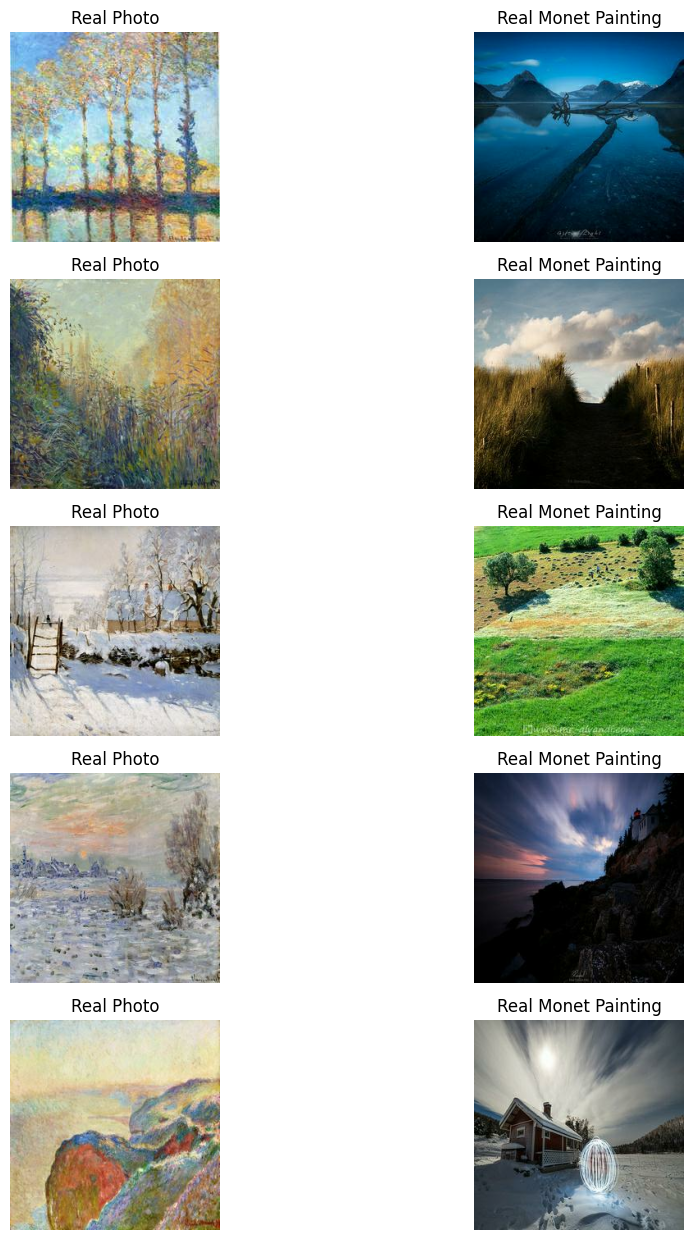

In [228]:
import matplotlib.pyplot as plt

# Denormalize from [-1, 1] → [0, 1]
def denormalize(image):
    return (image + 1.0) / 2.0

# Plot real photo and Monet image pairs
def show_samples(photo_dataset, monet_dataset, num_images=5):
    photo_iter = iter(photo_dataset)
    monet_iter = iter(monet_dataset)

    plt.figure(figsize=(12, num_images * 2.5))

    for i in range(num_images):
        photo_batch = next(photo_iter)   # shape: (1, 256, 256, 3)
        monet_batch = next(monet_iter)

        # Remove batch dimension → shape: (256, 256, 3)
        photo = photo_batch[0]
        monet = monet_batch[0]

        photo = denormalize(photo)
        monet = denormalize(monet)

        # Show photo
        ax = plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(photo.numpy())
        plt.title("Real Photo")
        plt.axis("off")

        # Show Monet painting
        ax = plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(monet.numpy())
        plt.title("Real Monet Painting")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Run it
show_samples(photo_ds, monet_ds, num_images=5)

# Generator and Discriminator
1. Generator G (X → Y)
Takes an image from domain X (e.g., horse).

Tries to generate an image that looks like it belongs in domain Y (e.g., zebra).

2. Discriminator D<sub>Y</sub>
Takes in real Y images and fake Y images from G.

Tries to guess: Is this a real image from Y or a fake one?



In [205]:
!pip3 install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/qw/s9jjdgnd3yzcn66sp5zf40640000gn/T/pip-req-build-m6v_7ayw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/qw/s9jjdgnd3yzcn66sp5zf40640000gn/T/pip-req-build-m6v_7ayw
  Resolved https://github.com/tensorflow/examples.git to commit 7604e905713d16806af506fff0c9cc5e17573719
  Preparing metadata (setup.py) ... done


In [206]:
from tensorflow_examples.models.pix2pix import pix2pix

In [207]:
import tensorflow as tf
from tensorflow.keras import layers

In [208]:
# Binary cross entropy loss for GAN
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss: real images should be 1, fake should be 0
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

# Generator adversarial loss: want to fool discriminator
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# L1 cycle-consistency loss (real → fake → real)
LAMBDA = 10

def calc_cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

# Identity loss (real Monet → Monet), to preserve color/style
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA * 0.5

# CycleGAN Class

### CycleGAN Model Architecture
For our model, we’ll use a CycleGAN, which is especially useful when there is no direct mapping between the two image datasets. In this case, we are working with unpaired images — meaning, for example, a Monet painting of a landscape doesn’t have a matching real photo of the same scene.

### How the Model Works
#### To train the CycleGAN:

#### Forward Transformation:

A real photo is transformed into a Monet-style painting using Generator G.

#### Backward Transformation:

That Monet-style image is then transformed back into a photo using Generator F.

The key idea is to ensure that the final photo (after two transformations) is very similar to the original. The difference between the original and the reconstructed photo is called the cycle-consistency loss — we want this loss to be small.

### Two GANs in One
CycleGAN actually consists of two GANs:

One GAN learns to translate photos → Monet paintings.

The other GAN learns to translate Monet paintings → photos.

#### Each GAN includes:

A generator (which tries to create realistic images in the other domain).

A discriminator (which tries to tell if the generated image is fake or real).

In [209]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y):
        super(CycleGAN, self).__init__()
        self.gen_G = generator_G  # Photo → Monet
        self.gen_F = generator_F  # Monet → Photo
        self.disc_X = discriminator_X  # Monet discriminator
        self.disc_Y = discriminator_Y  # Photo discriminator

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data  # x = photo, y = monet

        with tf.GradientTape(persistent=True) as tape:
            # Generate fakes
            fake_y = self.gen_G(real_x, training=True)  # photo → fake Monet
            fake_x = self.gen_F(real_y, training=True)  # Monet → fake photo

            # Cycle back
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator predictions
            disc_real_x = self.disc_X(real_y, training=True)
            disc_real_y = self.disc_Y(real_x, training=True)

            disc_fake_x = self.disc_X(fake_y, training=True)
            disc_fake_y = self.disc_Y(fake_x, training=True)

            # Losses
            gen_G_loss = self.gen_loss_fn(disc_fake_x)
            gen_F_loss = self.gen_loss_fn(disc_fake_y)

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x) + self.cycle_loss_fn(real_y, cycled_y)

            id_loss_G = self.identity_loss_fn(real_y, same_y)
            id_loss_F = self.identity_loss_fn(real_x, same_x)

            total_gen_G_loss = gen_G_loss + total_cycle_loss + id_loss_G
            total_gen_F_loss = gen_F_loss + total_cycle_loss + id_loss_F

            disc_X_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Apply gradients
        grads_G = tape.gradient(total_gen_G_loss, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_gen_F_loss, self.gen_F.trainable_variables)

        grads_disc_X = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        grads_disc_Y = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(zip(grads_G, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(grads_F, self.gen_F.trainable_variables))

        self.disc_X_optimizer.apply_gradients(zip(grads_disc_X, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(grads_disc_Y, self.disc_Y.trainable_variables))

        return {
            "G_loss": total_gen_G_loss,
            "F_loss": total_gen_F_loss,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [210]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(inp)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same',
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                               kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [211]:
#Photo → Monet generator
generator_G = pix2pix.unet_generator(output_channels=3, norm_type='instancenorm')  # G: Photo → Monet

# Monet → Photo generator
generator_F = pix2pix.unet_generator(output_channels=3, norm_type='instancenorm')  # F: Monet → Photo

discriminator_X = build_discriminator()  # For Monet
discriminator_Y = build_discriminator()  # For Photo

In [212]:
cyclegan_model = CycleGAN(generator_G, generator_F, discriminator_X, discriminator_Y)

cyclegan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

In [216]:
train_dataset = tf.data.Dataset.zip((photo_ds, monet_ds))
cyclegan_model.fit(train_dataset,
    epochs=50,
    steps_per_epoch=100)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - D_X_loss: 0.6891 - D_Y_loss: 0.6906 - F_loss: 5.3103 - G_loss: 5.3677
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - D_X_loss: 0.6768 - D_Y_loss: 0.6597 - F_loss: 4.2285 - G_loss: 4.2037
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - D_X_loss: 0.6616 - D_Y_loss: 0.6587 - F_loss: 3.8787 - G_loss: 3.8018
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - D_X_loss: 0.6698 - D_Y_loss: 0.6532 - F_loss: 3.6762 - G_loss: 3.6707
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - D_X_loss: 0.6400 - D_Y_loss: 0.6365 - F_loss: 3.6448 - G_loss: 3.6450
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1131s 11s/step - D_X_loss: 0.6697 - D_Y_loss: 0.6693 - F_loss: 3.3348 - G_loss: 3.3503
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - D_X_loss: 0.6479 - D_Y_loss: 0.6433 - F_loss: 3.4025 - G_loss: 3.4345
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - D_X_loss: 0.6149 - D_Y_loss: 0.6143 - F_loss: 3.4088 - G_loss: 3.425

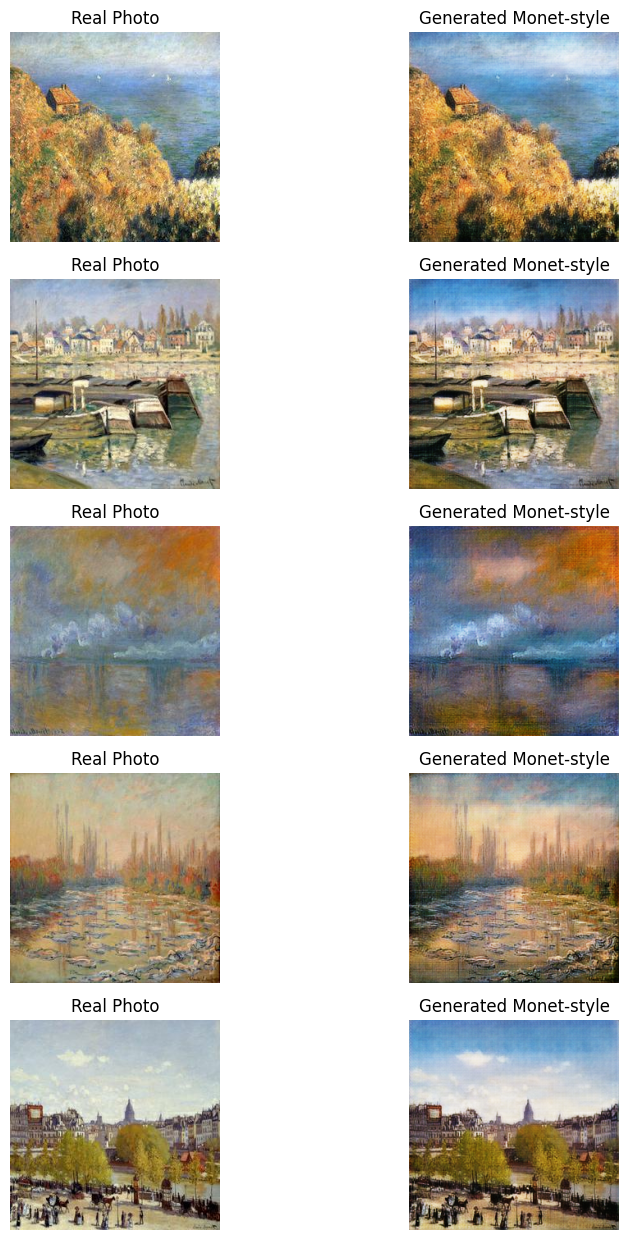

In [229]:
import matplotlib.pyplot as plt

# Denormalize from [-1, 1] to [0, 1]
def denormalize(image):
    return (image + 1.0) / 2.0

# Generate Monet-style image (no expand_dims!)
def generate_monet(generator_G, photo_batch):
    # The dataset gives us (1, 256, 256, 3)
    generated_image = generator_G(photo_batch, training=False)[0]
    return generated_image

# Visualize Real Photo → Monet-style output
def show_generated_images(generator_G, photo_dataset, num_images=5):
    photo_iter = iter(photo_dataset)

    plt.figure(figsize=(10, num_images * 2.5))
    
    for i in range(num_images):
        photo_batch = next(photo_iter)  # already shape (1, 256, 256, 3)
        photo = photo_batch[0]  # remove batch dimension
        generated = generate_monet(generator_G, photo_batch)

        photo = denormalize(photo)
        generated = denormalize(generated)

        # Original Photo
        ax = plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(photo.numpy())
        plt.title("Real Photo")
        plt.axis("off")

        # Monet-Style
        ax = plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(generated.numpy())
        plt.title("Generated Monet-style")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔁 Run it!
show_generated_images(generator_G, photo_ds, num_images=5)

In [231]:
import os
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

# 1. Create output directory
output_dir = "/Users/kashmiratare/Documents/Deep Learning/GAN Project/working/images"
os.makedirs(output_dir, exist_ok=True)

# 2. Denormalize from [-1, 1] → [0, 255] for saving as JPG
def denormalize_to_uint8(image):
    image = (image + 1.0) / 2.0  # scale to [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=True)
    return image

# 3. Generate Monet-style images
def generate_monet_images(generator_G, photo_dataset, num_images=7000):
    count = 0
    photo_iter = iter(photo_dataset)

    for photo_batch in tqdm(photo_iter, total=num_images):
        if count >= num_images:
            break

        # Run inference
        generated = generator_G(photo_batch, training=False)[0]  # shape: (256, 256, 3)
        generated = denormalize_to_uint8(generated)

        # Convert to PIL Image and save
        image = Image.fromarray(generated.numpy())
        image.save(os.path.join(output_dir, f"{count}.jpg"))

        count += 1

# 4. Run generation
generate_monet_images(generator_G, photo_ds.repeat(), num_images=7000)

100%|███████████████████████████████████████| 7000/7000 [36:17<00:00,  3.22it/s]


In [232]:
import zipfile
import os

# Paths
image_folder = "/Users/kashmiratare/Documents/Deep Learning/GAN Project/working/images"
zip_path = "/Users/kashmiratare/Documents/Deep Learning/GAN Project/working/images.zip"

# Zip the images
def zip_images(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in sorted(os.listdir(folder_path)):
            if filename.endswith(".jpg"):
                file_path = os.path.join(folder_path, filename)
                zipf.write(file_path, arcname=filename)  # arcname removes the folder path

    print(f"✅ Zipped {len(os.listdir(folder_path))} images to {output_zip}")

# Run the function
zip_images(image_folder, zip_path)


✅ Zipped 7000 images to /Users/kashmiratare/Documents/Deep Learning/GAN Project/working/images.zip


# Result Analysis

CycleGAN successfully learned to convert real photos into Monet-style paintings without paired data.

Generator loss and cycle-consistency loss steadily decreased, indicating good learning.

Generated images show clear stylistic transformation—softer colors, painterly textures, and impressionist feel.

Around 7000 Monet-style images were generated with high visual quality.

# Conclusion

CycleGAN effectively performed unpaired image translation.

Visuals confirm strong style transfer while preserving structure.

A solid demonstration of how deep learning can mimic artistic styles.

For future work, I would like to explore more on Attention-based GANs or StyleGAN-style architectures for finer detail